In [11]:
import glob
import os
import sys

import matplotlib
import matplotlib.pyplot as plt

params = {"axes.titlesize": "26", "xtick.labelsize": "20", "ytick.labelsize": "20"}
matplotlib.rcParams.update(params)

import numpy as np
import pandas as pd
import rasterio as rio

sys.path.append(os.path.join(os.path.abspath(""), "../"))
from utils.raster_utils import get_coord_from_raster
from utils.utilities import get_sample_name
from utils.io_utils import load_yaml


MASKS_ROOT = "/data"
ROI_LIST = ["1158_spring", "1868_summer", "1970_fall", "2017_winter"]
SENSOR = "lc"
METADATA_PATH = "/data/masks_metadata.csv"

val_fraction = 0.05
test_fraction = 0.05
lists_save_directory = "../config/dataset/lists"

In [12]:
metadata = pd.read_csv(METADATA_PATH, index_col=0)

In [13]:
metadata.head()

,filepath,filename,ROI,area,x0,y0,x1,y1,IGBP_9,IGBP_11,...,LCCS_SH_15,LCCS_LU_0,LCCS_LC_24,LCCS_LU_23,LCCS_SH_22,LCCS_LC_39,LCCS_LU_37,LCCS_SH_37,LCCS_LU_16,LCCS_SH_34
No,,,,,,,,,,,,,,,,,,,,,
0,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_lc_128_p81,1158_spring,128,600796.364733,6.094633e+06,603356.364733,6.092073e+06,15676,1723,...,0,0,0,0,0,0,0,0,0,0
1,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_lc_128_p48,1158_spring,128,595676.364733,6.095913e+06,598236.364733,6.093353e+06,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_lc_128_p660,1158_spring,128,599516.364733,6.069033e+06,602076.364733,6.066473e+06,11127,0,...,0,0,0,0,0,0,0,0,0,0
3,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_lc_128_p755,1158_spring,128,572636.364733,6.063913e+06,575196.364733,6.061353e+06,42783,0,...,0,0,0,0,0,0,0,0,0,0
4,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_lc_128_p834,1158_spring,128,599516.364733,6.061353e+06,602076.364733,6.058793e+06,2148,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
metadata["sample"] = metadata["filename"].apply(lambda x: get_sample_name(x))

### Build metadata with training labels

In [21]:
from dataset.dataset_utils import build_mask
from config.default import get_cfg_from_file
from utils.io_utils import load_yaml
from utils.raster_utils import raster_to_np
from utils.utilities import get_raster_filepath

training_cfg = get_cfg_from_file("/workspace/config/firstrun_focal.yml")
target_sensor_name = training_cfg.DATASET.MASK.SENSOR
mask_config = load_yaml("../" + training_cfg.DATASET.MASK.CONFIG)
class2label = mask_config["class2label"]
classes_count = len(class2label)
dataset_root = training_cfg.DATASET.ROOT

df_labels = metadata[["filepath", "sample", "ROI", "area", "x0", "y0", "x1", "y1"]]

# all_counts = []
# # Get target tensor
# for sample_name in df_labels["sample"].values:
#     target_raster_path = get_raster_filepath(
#         dataset_root, sample_name, target_sensor_name
#     )
#     target_np = raster_to_np(target_raster_path)
#     transformed_mask = build_mask(target_np, mask_config)
#     mask_unique = np.unique(transformed_mask, return_counts=True)
#     mask_counts = np.zeros(classes_count)
#     for i, count in zip(mask_unique[0], mask_unique[1]):
#         mask_counts[i] = count

#     all_counts.append(mask_counts)

# all_counts = np.stack(all_counts)
# df_labels_counts = pd.DataFrame(
#     all_counts,
#     index=df_labels["sample"],
#     columns=[class2label[i] for i in range(classes_count)],
# )

# df_labels = pd.merge(df_labels, df_labels_counts, left_on="sample", right_index=True)

df_labels = pd.read_csv("/data/training_labels.csv")

In [22]:
df_labels.head()

,No,filepath,sample,ROI,area,x0,y0,x1,y1,other,...,agricultural,barren,snow,water,dense_forest,open_forest,wetlands,grasslands,shrublands,tundra
0,0,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_128_p81,1158_spring,128,600796.364733,6.094633e+06,603356.364733,6.092073e+06,0.0,...,0.0,0.0,0.0,71.0,0.0,15676.0,1723.0,0.0,0.0,0.0
1,1,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_128_p48,1158_spring,128,595676.364733,6.095913e+06,598236.364733,6.093353e+06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_128_p660,1158_spring,128,599516.364733,6.069033e+06,602076.364733,6.066473e+06,0.0,...,54409.0,0.0,0.0,0.0,0.0,11127.0,0.0,0.0,0.0,0.0
3,3,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_128_p755,1158_spring,128,572636.364733,6.063913e+06,575196.364733,6.061353e+06,0.0,...,0.0,0.0,0.0,0.0,20466.0,42783.0,0.0,2287.0,0.0,0.0
4,4,/data/ROIs1158_spring/lc_128/ROIs1158_spring_l...,ROIs1158_spring_128_p834,1158_spring,128,599516.364733,6.061353e+06,602076.364733,6.058793e+06,0.0,...,63388.0,0.0,0.0,0.0,0.0,2148.0,0.0,0.0,0.0,0.0


In [23]:
areas = df_labels.groupby(["ROI","area"]).count().index.tolist()

# shuffle
np.random.seed(3)
np.random.shuffle(areas)

val_areas = areas[:int(val_fraction*len(areas))]
test_areas = areas[int(val_fraction*len(areas)):int((val_fraction+test_fraction)*len(areas))]
train_areas = areas[int((val_fraction+test_fraction)*len(areas)):]


In [24]:
print(len(train_areas))
print(len(val_areas))
print(len(test_areas))

227
12
13


In [25]:
metadata_train = df_labels[df_labels.set_index(['ROI','area']).index.isin(train_areas)]
metadata_val = df_labels[df_labels.set_index(['ROI','area']).index.isin(val_areas)]
metadata_test = df_labels[df_labels.set_index(['ROI','area']).index.isin(test_areas)]

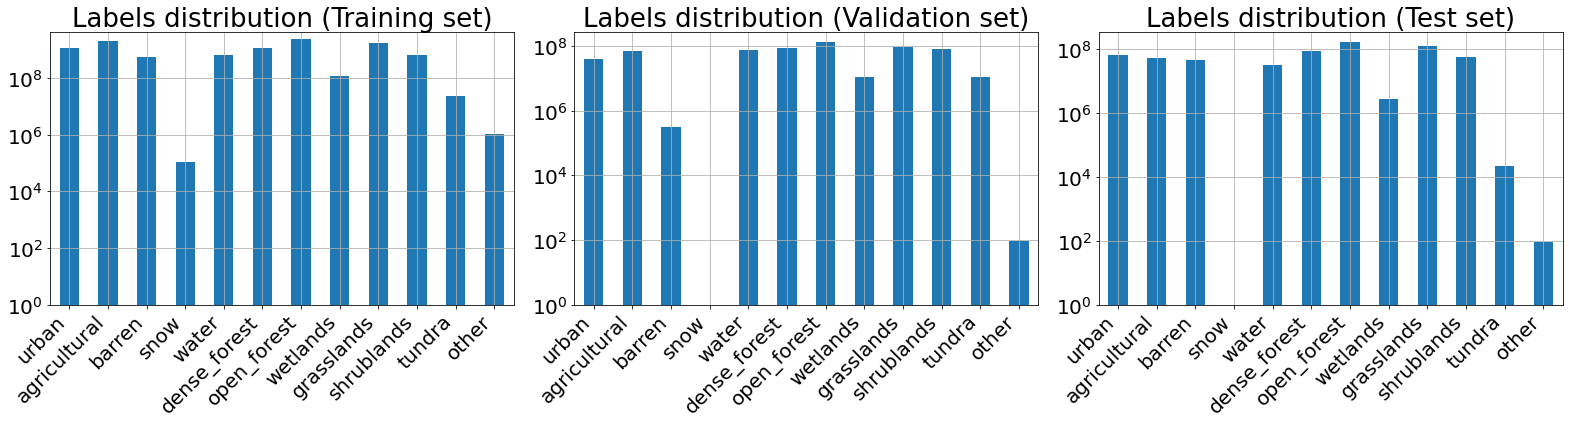

In [26]:
def plot_hists(subgrids_train, subgrids_val, subgrids_test):

    fig, ax = plt.subplots(1,3, figsize=(22,6))
    subgrids_train[list(class2label.values())].sum().plot.bar(ax=ax[0])
    subgrids_val[list(class2label.values())].sum().plot.bar(ax=ax[1])
    subgrids_test[list(class2label.values())].sum().plot.bar(ax=ax[2])
    ax[0].set_yscale("log")
    ax[1].set_yscale("log")
    ax[2].set_yscale("log")
    ax[0].set_ylim(bottom=1)
    ax[1].set_ylim(bottom=1)
    ax[2].set_ylim(bottom=1)
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[0].set_title("Labels distribution (Training set)")
    ax[1].set_title("Labels distribution (Validation set)")
    ax[2].set_title("Labels distribution (Test set)")
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()

plot_hists(metadata_train, metadata_val, metadata_test)

#### There is no snow in validation, let's add it

In [27]:
df_labels[df_labels["snow"] > 0].groupby(["ROI","area"]).sum()

No            x0            y0            x1  \
ROI         area                                                     
1158_spring 8      50512  4.894339e+06  5.226813e+07  4.919939e+06   
1868_summer 93    908488  8.965412e+06  5.088891e+07  8.996132e+06   
            114   319533  2.238789e+06  1.949081e+07  2.249029e+06   

                            y1  other  urban  agricultural    barren     snow  \
ROI         area                                                                
1158_spring 8     5.224253e+07    0.0    0.0           0.0   75215.0  37774.0   
1868_summer 93    5.085819e+07    0.0    0.0           0.0  331213.0  60468.0   
            114   1.948057e+07    0.0    0.0           0.0   62474.0   8532.0   

                  water  dense_forest  open_forest  wetlands  grasslands  \
ROI         area                                                           
1158_spring 8       0.0       61590.0      24892.0   14628.0    363541.0   
1868_summer 93      0.0           0.0          0.0       0.0    215959.0   
            114     0.0           0.0          0.0       0.0     92306.0   

                  shrublands    tundra  
ROI         area                        
1158_spring 8            0.0   77720.0  
1868_summer 93           0.0  178792.0  
            114          0.0   98832.0

226
13
13


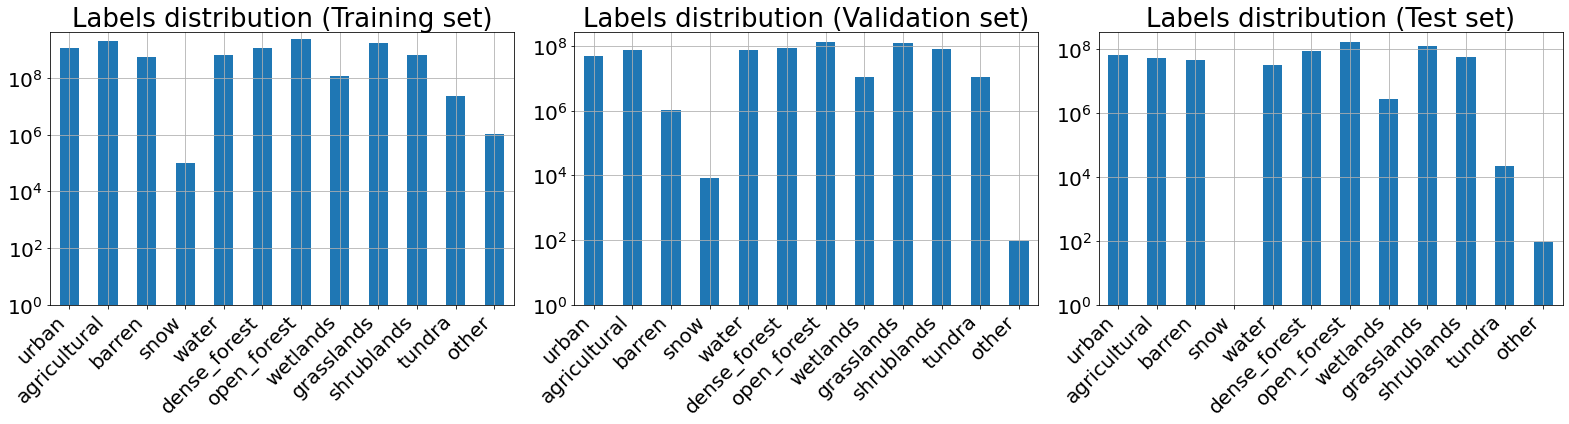

In [28]:
snow_area = ("1868_summer",114)

train_areas.remove(snow_area)
val_areas.append(snow_area)

print(len(train_areas))
print(len(val_areas))
print(len(test_areas))

metadata_train = df_labels[df_labels.set_index(['ROI','area']).index.isin(train_areas)]
metadata_val = df_labels[df_labels.set_index(['ROI','area']).index.isin(val_areas)]
metadata_test = df_labels[df_labels.set_index(['ROI','area']).index.isin(test_areas)]

plot_hists(metadata_train, metadata_val, metadata_test)

In [29]:
print(metadata_train.shape)
print(metadata_val.shape)
print(metadata_test.shape)

(161320, 21)
(9805, 21)
(9537, 21)


In [30]:
np.savetxt(os.path.join(lists_save_directory, "train.txt"), metadata_train.values, fmt="%s")
np.savetxt(os.path.join(lists_save_directory, "val.txt"), metadata_val.values, fmt="%s")
np.savetxt(os.path.join(lists_save_directory, "test.txt"), metadata_test.values, fmt="%s")

### Finally, let's count classes

In [31]:
counts = metadata_train[list(class2label.values())].sum()

for i, label in enumerate(class2label.values()):
    print(f"Count for class{i} ({label}): {counts[label]}")

Count for class0 (urban): 1147541851.0
Count for class1 (agricultural): 1989138184.0
Count for class2 (barren): 572379667.0
Count for class3 (snow): 98242.0
Count for class4 (water): 666673620.0
Count for class5 (dense_forest): 1166133595.0
Count for class6 (open_forest): 2503533571.0
Count for class7 (wetlands): 115726637.0
Count for class8 (grasslands): 1732259150.0
Count for class9 (shrublands): 654067812.0
Count for class10 (tundra): 23677347.0
Count for class11 (other): 1037844.0
